In [ ]:
!pip install torch torchvision transformers accelerate deepspeed flash-attn peft


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
# Install Hugging Face datasets library (only needs to run once)
!pip install datasets

from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# GPT-2 has no pad token, so use eos_token as padding
tokenizer.pad_token = tokenizer.eos_token

# Load a small portion of the WikiText dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:1%]")

# Confirm key is 'text'
print(dataset[0])  # Should return {'text': 'some sample line...'}

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        return_special_tokens_mask=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Tokenize entire dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Define a data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Create dataloader
train_dataloader = DataLoader(
    tokenized_dataset,
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator
)


{'text': ''}


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]  # 👈 Important!
)


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

In [ ]:
# STEP 1: Install necessary packages
!pip install transformers datasets peft

# STEP 2: Imports
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from peft import get_peft_model, LoraConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch

# STEP 3: Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token

# STEP 4: Load and prepare dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:1%]")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        return_special_tokens_mask=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]  # 🔥 this avoids raw string errors
)

# STEP 5: Data collator and DataLoader
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataloader = DataLoader(
    tokenized_dataset,
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator
)

# STEP 6: Load GPT-2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))  # Adjust embedding size
model.config.pad_token_id = tokenizer.pad_token_id

# STEP 7: Apply PEFT - LoRA
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],  # for GPT2
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

# STEP 8: Training loop
optimizer = AdamW(model.parameters(), lr=2e-5)
model.train()

for step, batch in enumerate(train_dataloader):
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if step % 10 == 0:
        print(f"Step {step} - Loss: {loss.item()}")

    if step == 50:  # limit steps for demo
        break

# STEP 9: Save model
model.save_pretrained("gpt2-lora-finetuned")
tokenizer.save_pretrained("gpt2-lora-finetuned")


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step 0 - Loss: 6.524035930633545
Step 10 - Loss: 4.741588115692139
Step 20 - Loss: 4.201550006866455
Step 30 - Loss: 5.057910442352295
Step 40 - Loss: 4.3784098625183105
Step 50 - Loss: 6.885462760925293


('gpt2-lora-finetuned/tokenizer_config.json',
 'gpt2-lora-finetuned/special_tokens_map.json',
 'gpt2-lora-finetuned/vocab.json',
 'gpt2-lora-finetuned/merges.txt',
 'gpt2-lora-finetuned/added_tokens.json',
 'gpt2-lora-finetuned/tokenizer.json')

In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load base model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2-lora-finetuned")
model = AutoModelForCausalLM.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Load LoRA adapter
model = PeftModel.from_pretrained(model, "gpt2-lora-finetuned")

# Text generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Generate text from a prompt
output = text_generator("Once upon a time", max_length=50, do_sample=True)
print(output[0]['generated_text'])


Device set to use cpu
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCa

Once upon a time and a place, the two forces clashed violently. A second and much greater battle was now underway.

It was indeed too late for her. Once it began, she only felt a small amount of nausea and shiver run


In [ ]:
for name, param in model.named_parameters():
    if "embed" in name or "norm" in name:
        param.requires_grad = True


In [ ]:
# Generate synthetic long samples (2048 tokens)
long_texts = [" ".join(["Once upon a time"] * 150)] * 10  # repeat prompt to make it long

from datasets import Dataset

dataset = Dataset.from_dict({"text": long_texts})

def tokenize_long(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=2048,  # extend context
        return_tensors="pt"
    )

tokenized_dataset = dataset.map(tokenize_long, remove_columns=["text"])


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
import torch

def s2_attention(qkv, group_size=128):
    """
    Simulate Shifted Sparse Attention (S2-Attn) logic.

    Args:
        qkv: tensor of shape (batch, seq_len, 3, heads, dim)
        group_size: size of sparse local attention blocks
    Returns:
        grouped attention tensor
    """
    batch, seq_len, _, heads, dim = qkv.shape
    qkv = qkv.view(batch, seq_len, 3, heads, dim)

    q, k, v = qkv[:, :, 0], qkv[:, :, 1], qkv[:, :, 2]

    # Split sequence into non-overlapping groups
    q_groups = q.view(batch, seq_len // group_size, group_size, heads, dim)
    k_groups = k.view(batch, seq_len // group_size, group_size, heads, dim)
    v_groups = v.view(batch, seq_len // group_size, group_size, heads, dim)

    # Shift k and v (e.g., roll left by half group size)
    shift = group_size // 2
    k_shifted = k_groups.roll(-shift, dims=2)
    v_shifted = v_groups.roll(-shift, dims=2)

    # Perform block-local attention (simulate with dot product here)
    attn_scores = torch.matmul(q_groups, k_shifted.transpose(-1, -2)) / (dim ** 0.5)
    attn_probs = torch.nn.functional.softmax(attn_scores, dim=-1)
    output = torch.matmul(attn_probs, v_shifted)

    # Reshape back
    output = output.view(batch, seq_len, heads, dim)
    return output


In [ ]:
import torch
import torch.nn as nn

class S2AttentionBlock(nn.Module):
    def __init__(self, dim, heads=8, group_size=128):
        super().__init__()
        self.heads = heads
        self.dim = dim
        self.group_size = group_size
        self.qkv_proj = nn.Linear(dim, dim * 3)
        self.out_proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, T, D = x.shape  # Batch, SeqLen, EmbDim
        qkv = self.qkv_proj(x)
        qkv = qkv.view(B, T, 3, self.heads, D // self.heads)

        # apply S2-attention
        attn_output = s2_attention(qkv, group_size=self.group_size)

        # project output
        attn_output = attn_output.view(B, T, D)
        return self.out_proj(attn_output)


In [ ]:
dummy_input = torch.randn(2, 512, 256)  # batch=2, seq_len=512, embed_dim=256
s2_block = S2AttentionBlock(dim=256, heads=8, group_size=64)

output = s2_block(dummy_input)
print(output.shape)  # Should be [2, 512, 256]


torch.Size([2, 512, 256])


In [ ]:
class MiniTransformer(nn.Module):
    def __init__(self, vocab_size=50257, dim=256, heads=8, seq_len=512, group_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, dim))
        self.attn = S2AttentionBlock(dim=dim, heads=heads, group_size=group_size)
        self.norm = nn.LayerNorm(dim)
        self.lm_head = nn.Linear(dim, vocab_size)

    def forward(self, input_ids):
        x = self.embedding(input_ids) + self.pos_embedding[:, :input_ids.size(1), :]
        x = self.attn(self.norm(x))
        return self.lm_head(x)


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Create long dummy text
long_texts = ["Once upon a time " * 100] * 16  # ~1000 tokens each

# Tokenize and prepare dataset
class DummyDataset(Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    def __len__(self):
        return self.encodings["input_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.encodings.items()}

dataset = DummyDataset(long_texts)
dataloader = DataLoader(dataset, batch_size=2)

# Init model
model = MiniTransformer()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

# Train loop (tiny, for demo)
model.train()
for batch in dataloader:
    input_ids = batch["input_ids"]
    labels = input_ids.clone()
    logits = model(input_ids)
    loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Loss:", loss.item())


Loss: 10.802481651306152
Loss: 10.744050979614258
Loss: 10.684550285339355
Loss: 10.623233795166016
Loss: 10.559332847595215
Loss: 10.492082595825195
Loss: 10.420750617980957
Loss: 10.344633102416992


In [ ]:

def count_trainable_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    percent = 100 * trainable_params / total_params
    print(f"Trainable params: {trainable_params:,} || All params: {total_params:,} || Trainable%: {percent:.2f}%")


In [ ]:
count_trainable_params(model)


Trainable params: 26,176,593 || All params: 26,176,593 || Trainable%: 100.00%


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)


In [ ]:
from transformers import pipeline

long_prompt = "In the beginning " * 200

# Truncate to 1024
encoded = tokenizer(long_prompt, truncation=True, max_length=1024, return_tensors="pt")
truncated_input = tokenizer.decode(encoded.input_ids[0])

text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
output = text_generator(truncated_input, max_length=1024, do_sample=True)

print(output[0]['generated_text'])


Device set to use cpu
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCa

In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginni

Step 0 - Loss: 5.9179
Step 10 - Loss: 4.8782
Step 20 - Loss: 4.4572
Step 30 - Loss: 6.3161
Step 40 - Loss: 4.7117
Step 50 - Loss: 4.1649


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


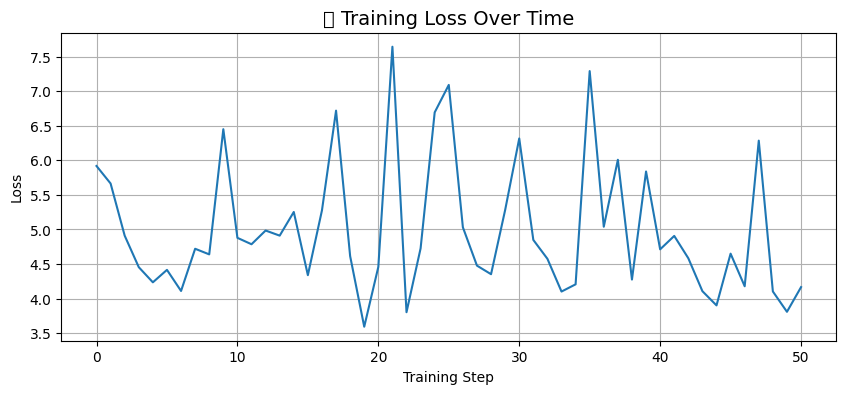

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


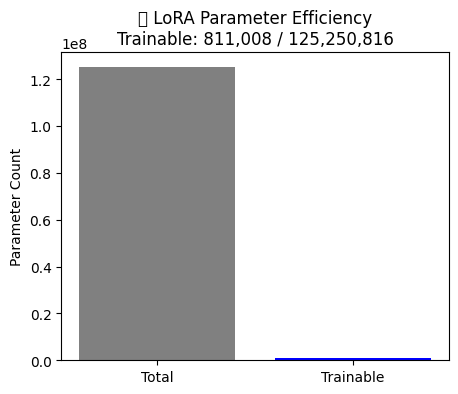

📌 === Prompt (Truncated) ===
In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the begi...

📌 === Generated Output ===
In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning In the beginning  In the beginning In the beginning  In the beginning  In the beginning  In the beginning  In the beginning  In the beginning  Out in mid-first verse In the beginning  Out in the beginning  In the beginning  Outside in mid-third verse
Back to Top


In [ ]:
import torch
import matplotlib.pyplot as plt

# === Initialize training ===
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_values = []

# === Training loop ===
model.train()
for step, batch in enumerate(train_dataloader):
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    if step % 10 == 0:
        print(f"Step {step} - Loss: {loss.item():.4f}")

    if step == 50:  # limit training for demo
        break

# === 1. Plot Training Loss ===
plt.figure(figsize=(10, 4))
plt.plot(loss_values)
plt.title("📉 Training Loss Over Time", fontsize=14)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# === 2. Parameter Efficiency ===
def count_trainable_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_trainable_params(model)

plt.figure(figsize=(5, 4))
plt.bar(["Total", "Trainable"], [total_params, trainable_params], color=["gray", "blue"])
plt.title(f"📊 LoRA Parameter Efficiency\nTrainable: {trainable_params:,} / {total_params:,}", fontsize=12)
plt.ylabel("Parameter Count")
plt.show()

# === 3. Display Prompt + Generated Text ===
print("📌 === Prompt (Truncated) ===")
print(long_prompt[:300] + "...\n")

print("📌 === Generated Output ===")
print(output[0]['generated_text'][-500:])
